In [1]:
!pip install utm

  Preparing metadata (setup.py) ... done
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6084 sha256=45a4cf4b7f61f45234cb260e99ef05371ce3e7007d731ba19796acd055963f9f
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm


In [2]:
import pandas as pd
import numpy as np
import utm
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.optimize import least_squares
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

In [ ]:
data = pd.read_csv('/content/unique_data_2.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Node ID    60000 non-null  int64  
 1   Latitude   60000 non-null  float64
 2   Longitude  60000 non-null  float64
 3   RSSI 1     60000 non-null  int64  
 4   RSSI 2     60000 non-null  int64  
 5   RSSI 3     60000 non-null  int64  
 6   SNR 1      60000 non-null  int64  
 7   SNR 2      60000 non-null  int64  
 8   SNR 3      60000 non-null  int64  
 9   TDoA 1     60000 non-null  float64
 10  TDoA 2     60000 non-null  float64
 11  TDoA 3     60000 non-null  float64
dtypes: float64(5), int64(7)
memory usage: 5.5 MB


In [ ]:
display(data[:4])

,Node ID,Latitude,Longitude,RSSI 1,RSSI 2,RSSI 3,SNR 1,SNR 2,SNR 3,TDoA 1,TDoA 2,TDoA 3
0,1,30.095533,-95.990582,-67,-53,-62,12,16,26,0.402285,0.063060,0.774908
1,2,30.090537,-95.992485,-63,-62,-70,24,22,29,0.020667,0.321181,0.017177
2,3,30.102261,-95.986619,-55,-68,-52,12,20,17,0.864311,0.488032,0.704004
3,4,30.087665,-95.993680,-52,-59,-54,14,10,18,0.423811,0.844232,0.760452


In [ ]:
data.describe()

,Node ID,Latitude,Longitude,RSSI 1,RSSI 2,RSSI 3,SNR 1,SNR 2,SNR 3,TDoA 1,TDoA 2,TDoA 3
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000,60000.00000,60000.000000,60000.000000,60000.000000,60000.000000
mean,30000.500000,30.093886,-95.990689,-60.504683,-60.447700,-60.497750,19.53540,19.47475,19.498567,0.501709,0.500176,0.497083
std,17320.652413,0.004527,0.002092,5.769980,5.757996,5.765335,5.76171,5.75340,5.750969,0.288229,0.289295,0.288724
min,1.000000,30.082185,-95.995767,-70.000000,-70.000000,-70.000000,10.00000,10.00000,10.000000,0.000051,0.000014,0.000016
25%,15000.750000,30.090661,-95.992200,-65.000000,-65.000000,-65.000000,15.00000,14.00000,14.000000,0.253426,0.248816,0.246786
50%,30000.500000,30.094235,-95.990688,-60.000000,-60.000000,-60.000000,20.00000,19.00000,19.000000,0.502326,0.498890,0.495978
75%,45000.250000,30.097222,-95.989180,-55.000000,-55.000000,-56.000000,25.00000,24.00000,24.000000,0.751716,0.751215,0.746925
max,60000.000000,30.103971,-95.985614,-51.000000,-51.000000,-51.000000,29.00000,29.00000,29.000000,0.999946,0.999988,0.999985


# Calcule intersection

# modeling

In [ ]:
def eval(model,X,y):
  # define the evaluation procedure
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  # evaluate the model and collect the scores
  n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  # force the scores to be positive
  n_scores = np.absolute(n_scores)
  # summarize performance
  print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

import matplotlib.pyplot as plt
# Create a scatter plot
def plotcomp(y_test,y_pred):
    plt.rcParams["figure.figsize"] = (40,40)
    #plt.scatter(y_test[:,0],y_test[:,1], color='blue')
    #plt.scatter(y_pred_lt[:,0], y_pred_lt[:,1], color='red')
    plt.plot(y_test[:,0],y_test[:,1],'o', color='blue', markersize=8)
    plt.plot(y_pred[:,0], y_pred[:,1],'o', color='red', markersize=5)
    # Add a circle
    #circle = plt.Circle((0, 0), radius=0.5, color='black')
    #plt.add_patch(circle)

    # Set the title and labels
    plt.title('XY Graph with Circle')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # Show the plot
    plt.show()


In [ ]:
X = data.drop(columns=['Node ID','Latitude', 'Longitude']).to_numpy()

y = data[['Latitude', 'Longitude']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [ ]:
# display features
display(X_train[:3])

array([[-56.        , -69.        , -66.        ,  21.        ,
         11.        ,  15.        ,   0.24401166,   0.83399296,
          0.8620495 ],
       [-68.        , -53.        , -51.        ,  15.        ,
         11.        ,  14.        ,   0.47467103,   0.55282639,
          0.96138423],
       [-65.        , -55.        , -61.        ,  29.        ,
         14.        ,  19.        ,   0.16035248,   0.91916071,
          0.53059516]])

In [ ]:
#Display target

display(y_train[:3])

array([[ 30.0888053 , -95.99317771],
       [ 30.09239825, -95.99120838],
       [ 30.0983125 , -95.98867483]])

In [ ]:
print(X.shape, y.shape, X_train.shape,X_test.shape)

(60000, 9) (60000, 2) (42000, 9) (18000, 9)


**Linear Regression for Multioutput Regression**

The example below fits a linear regression model on the multioutput regression dataset, then makes a single prediction with the fit model.

In [ ]:
# linear regression for multioutput regression
from sklearn.linear_model import LinearRegression
# define model
model_lr = LinearRegression()
# fit model
model_lr.fit(X_train, y_train)
# make a prediction
y_pred_lr = model_lr.predict(X_test)
# summarize prediction
print(y_pred_lr[0])
# Calculate the score
score_lt = model_lr.score(X_test, y_pred_lr)
# Print the score
print(score_lt)

print('Latitude MSE  :',mean_squared_error(y_test[:,0], y_pred_lr[:,0]))
print('Longitude MSE :',mean_squared_error(y_test[:,1], y_pred_lr[:,1]))
print('coefficient of determination: ',r2_score(y_test, y_pred_lr))
eval(model_lr,y_test, y_pred_lr)

[ 30.09399416 -95.99064759]
1.0
Latitude MSE  : 2.0550269726788276e-05
Longitude MSE : 4.381583236167864e-06
coefficient of determination:  5.2942263145117074e-06
MAE: 0.000 (0.000)


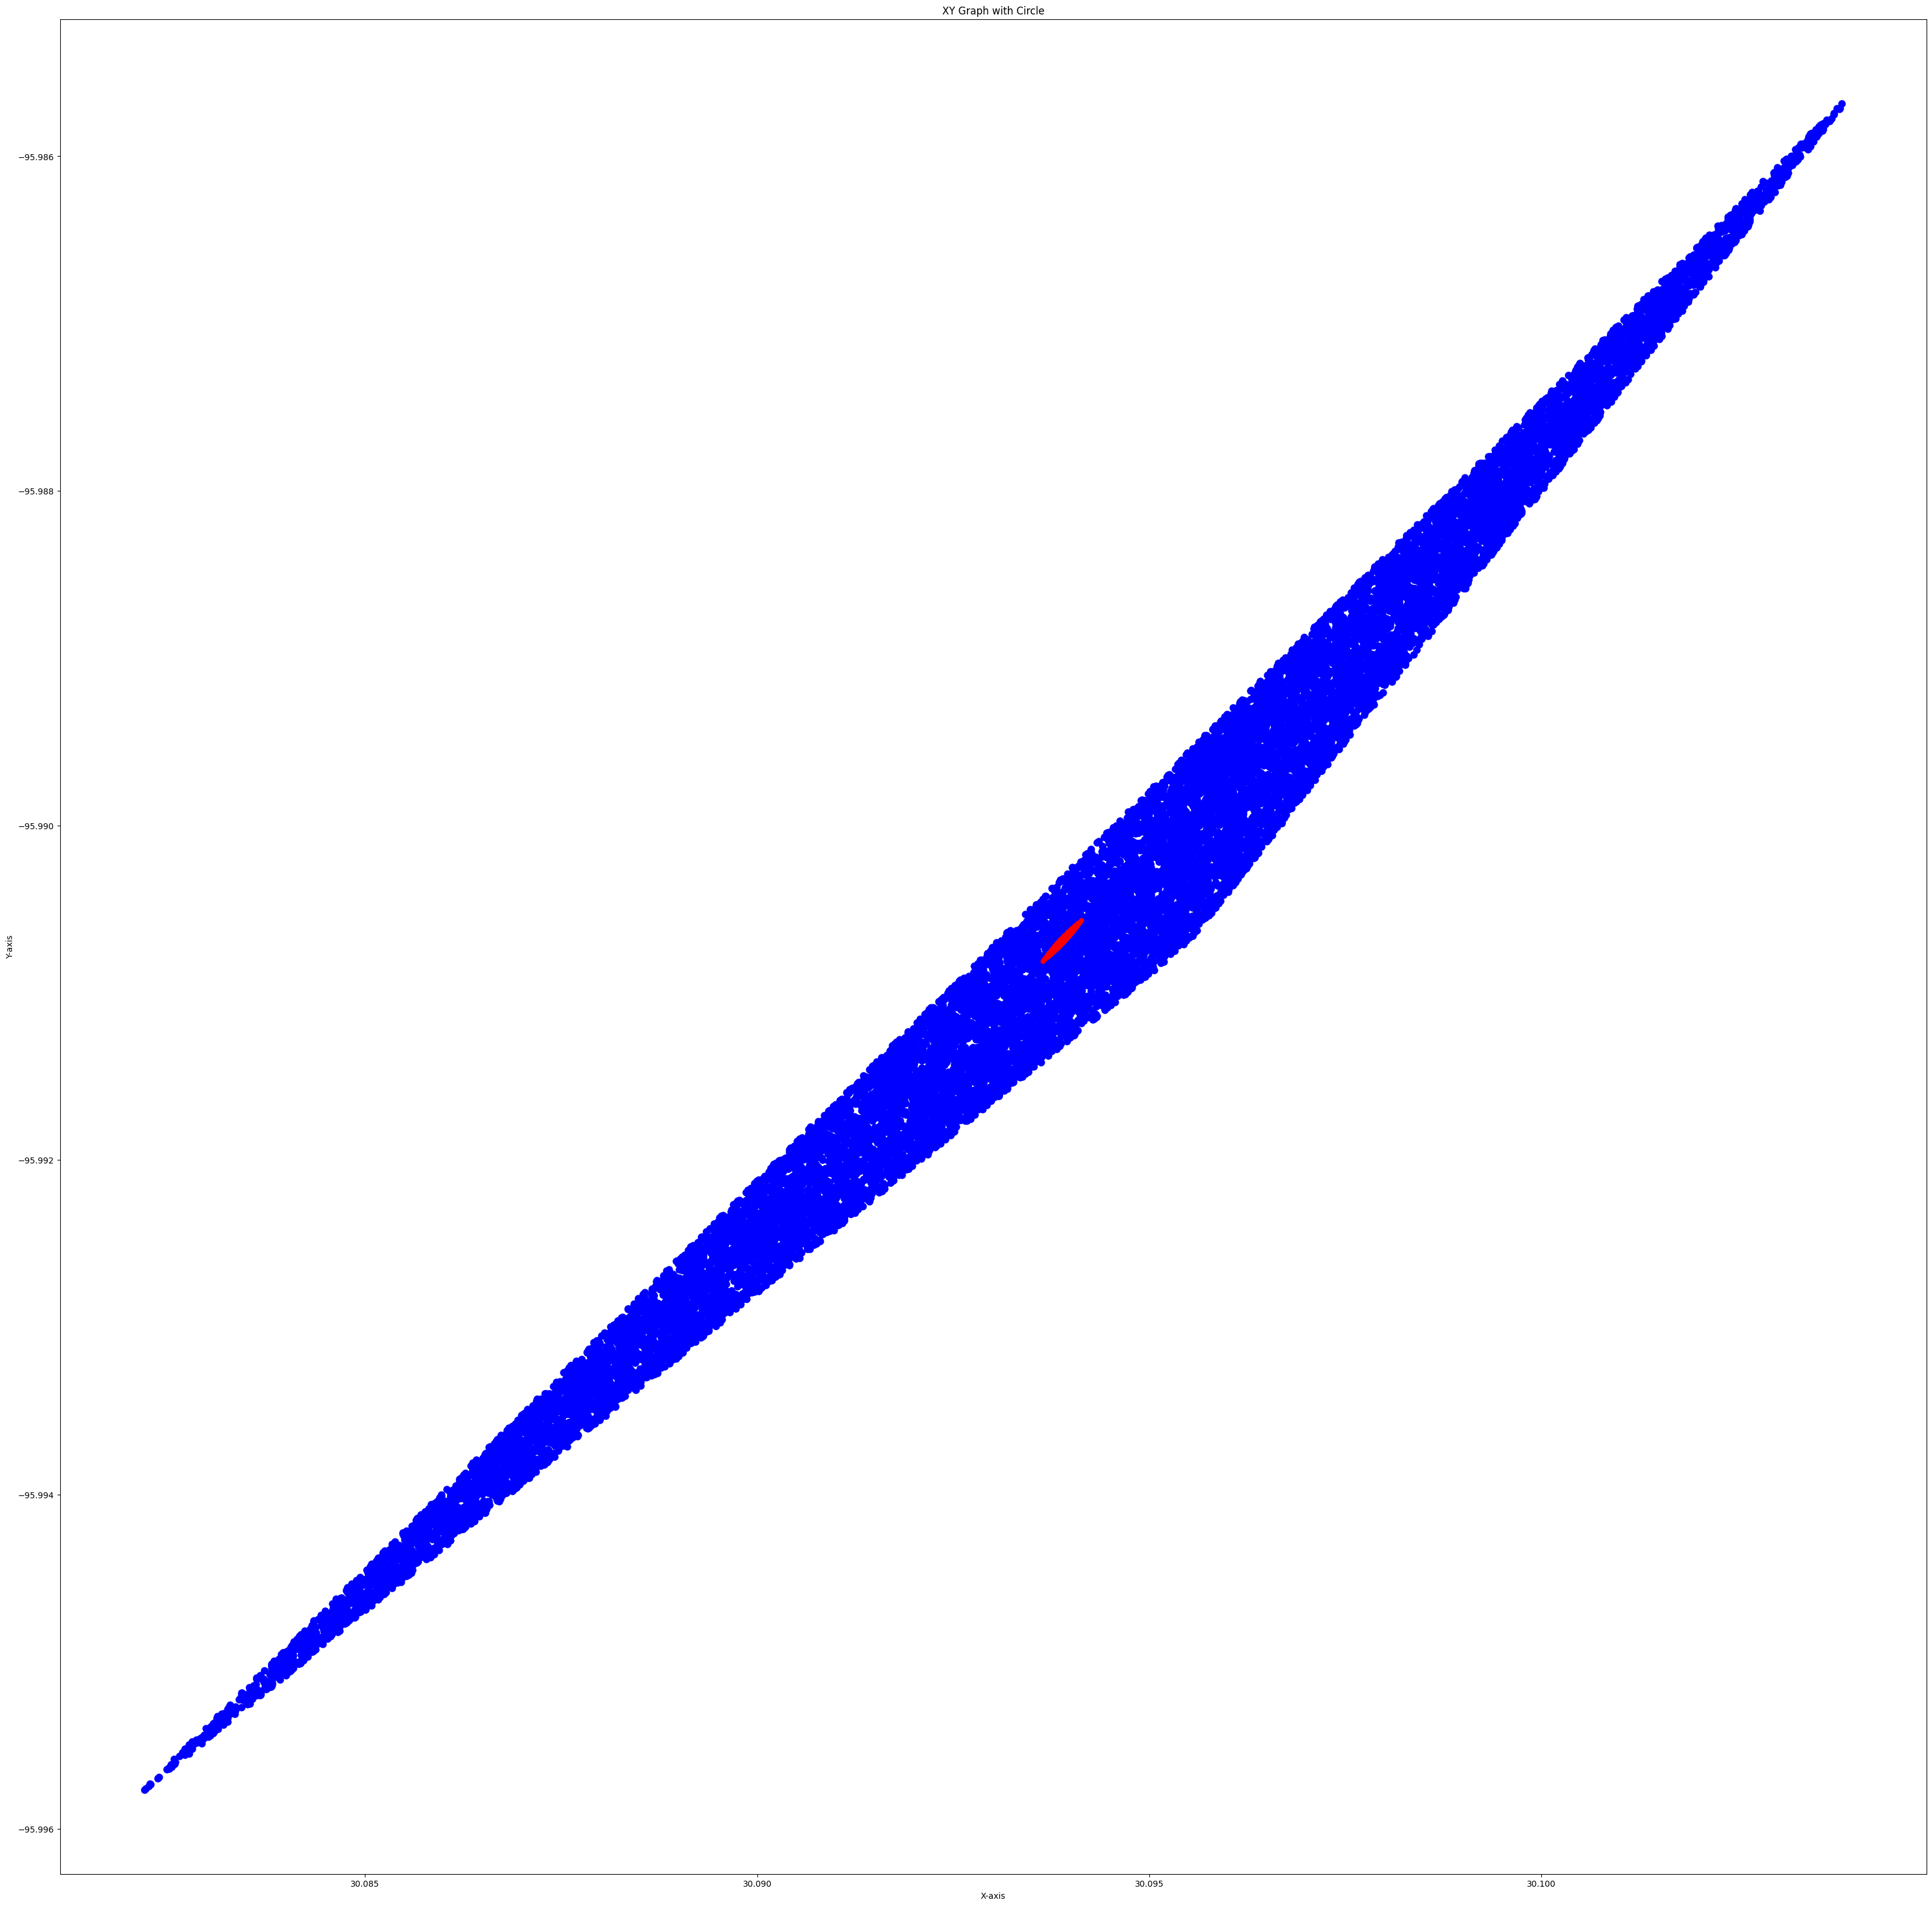

In [ ]:

plotcomp(y_test,y_pred_lr)

[ 30.09335273 -95.99090674]
1.0
Latitude MSE  : 2.1101070197737678e-05
Longitude MSE : 4.497768716769626e-06
coefficient of determination:  -0.026654244455019738
MAE: 0.000 (0.000)


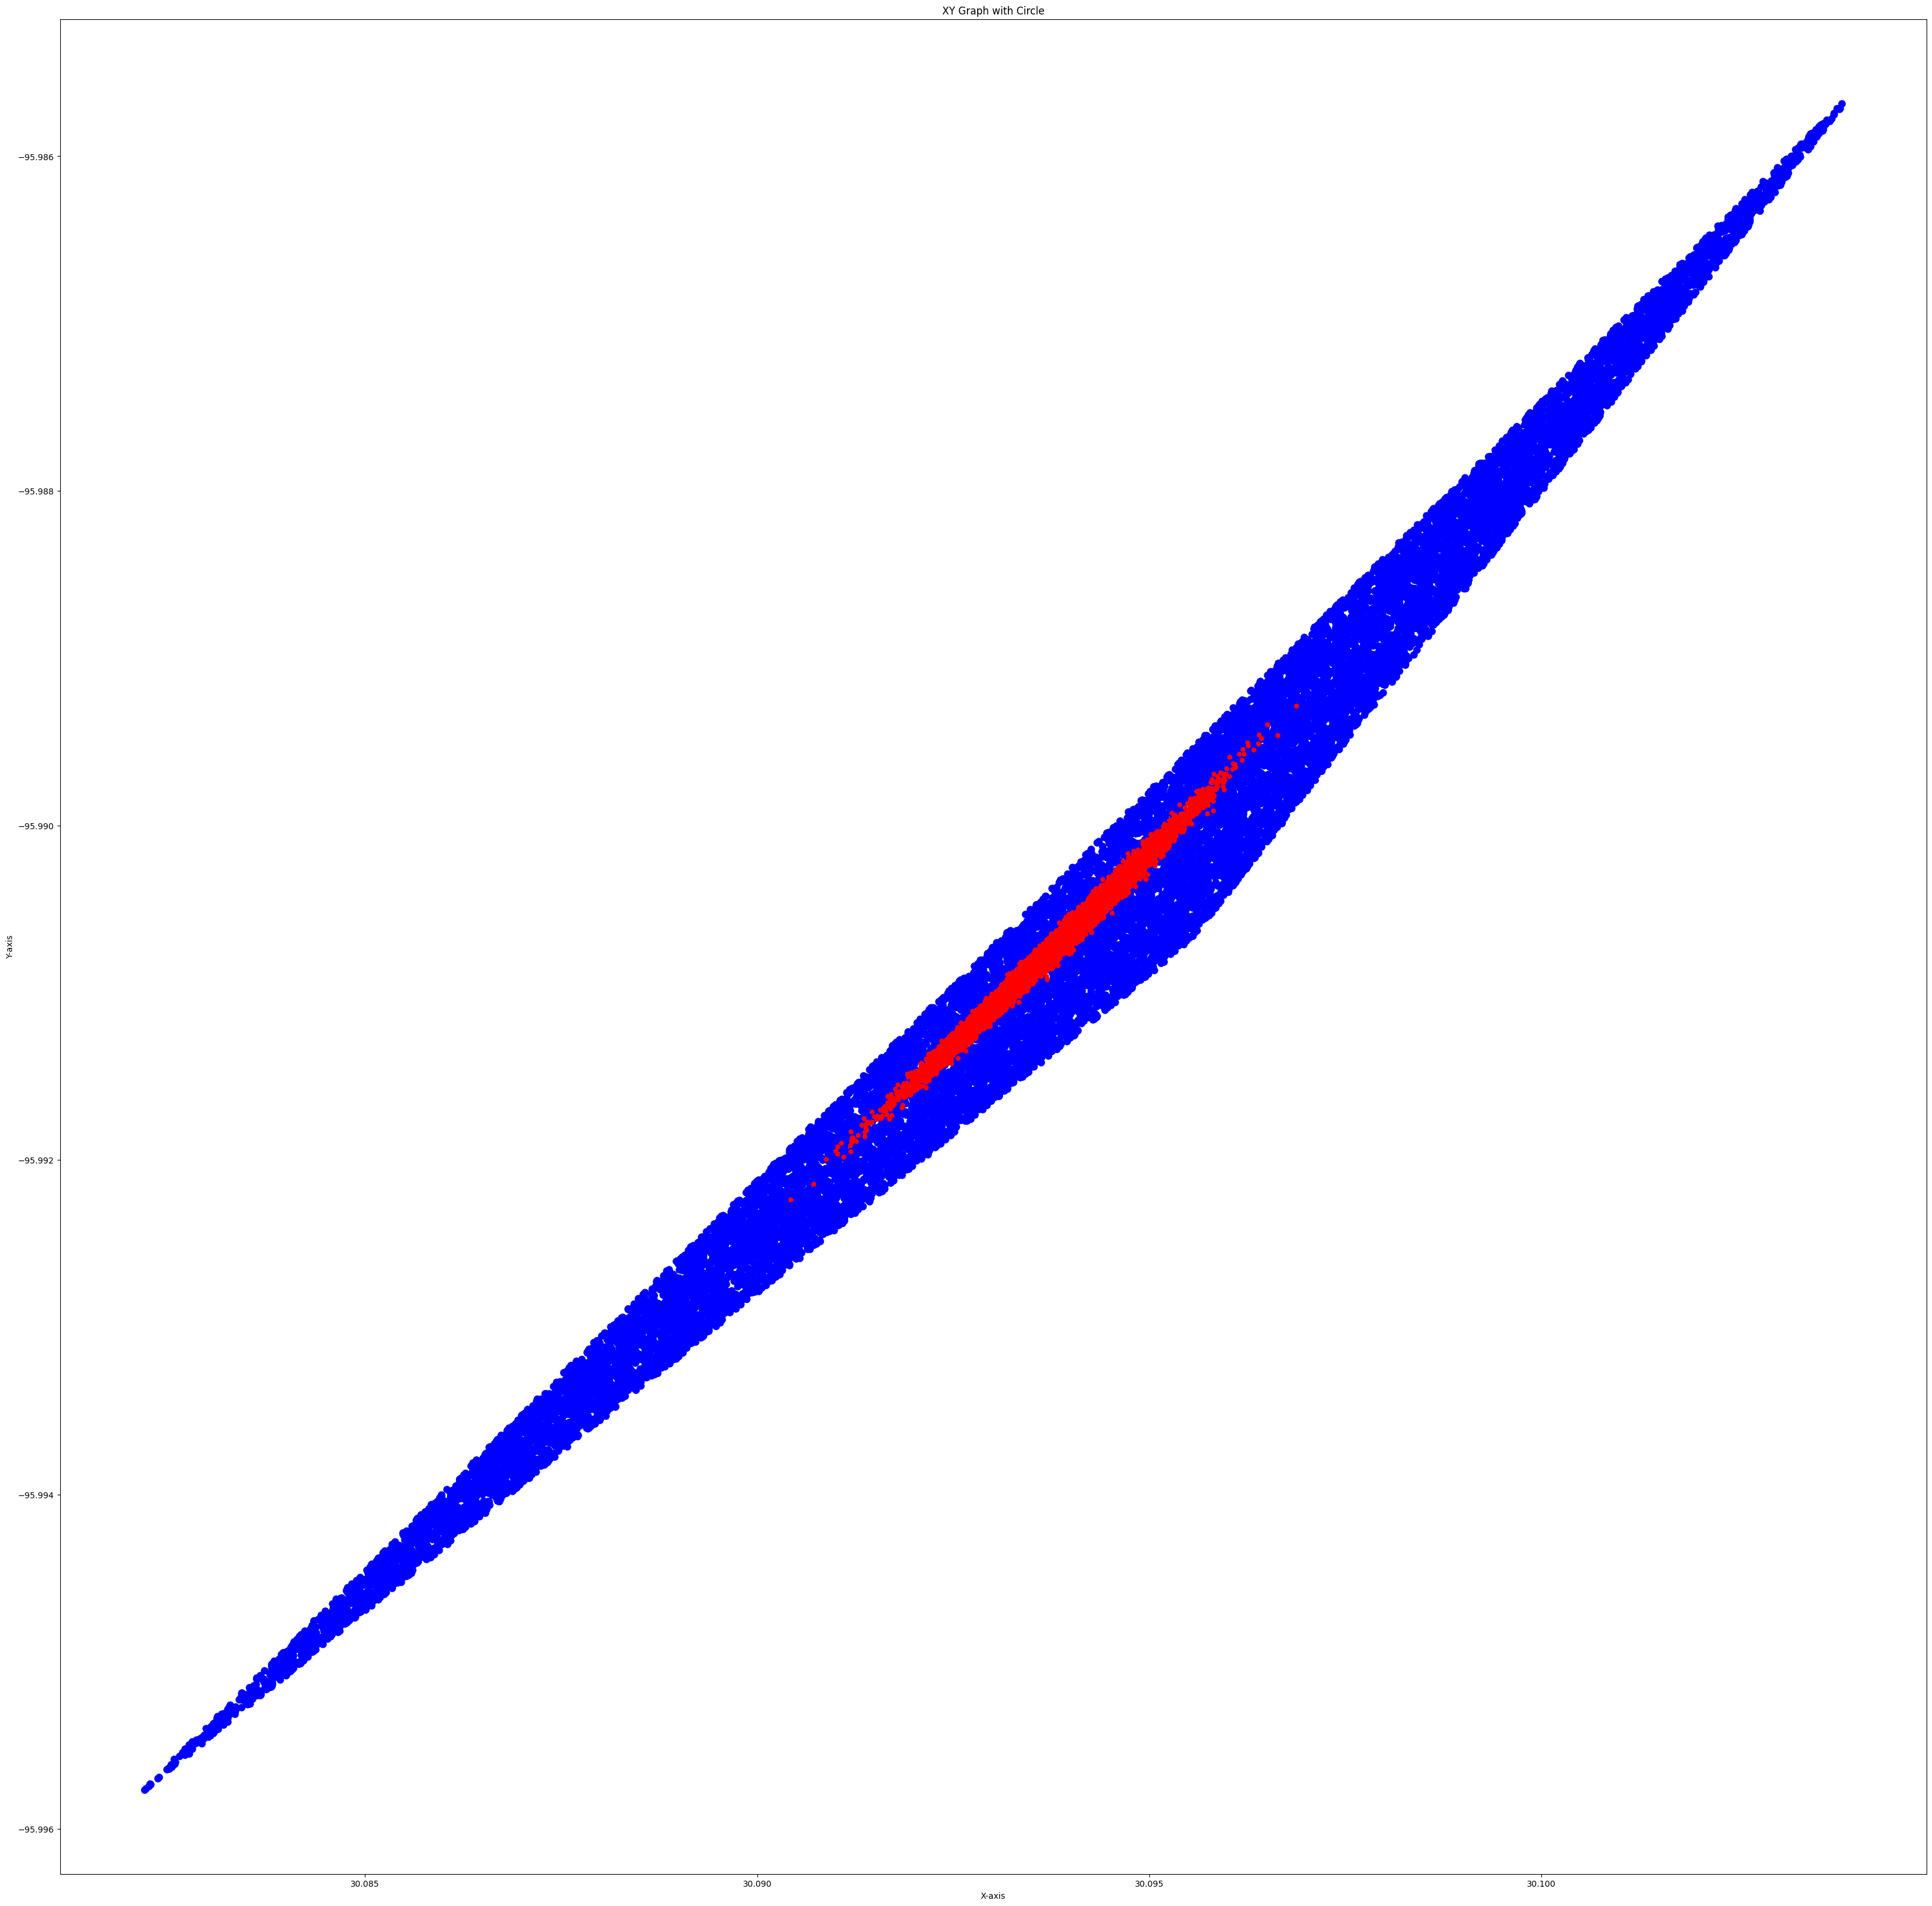

In [ ]:
# linear regression for multioutput regression
from sklearn.ensemble import RandomForestRegressor

# define model
#model_rf = MultiOutputRegressor(RandomForestRegressor())
model_rf = RandomForestRegressor()
# fit model
model_rf.fit(X_train, y_train)
# make a prediction
y_pred_rf = model_rf.predict(X_test)
# summarize prediction
print(y_pred_rf[0])
# Calculate the score
score = model_rf.score(X_test, y_pred_rf)

# Print the score
print(score)
print('Latitude MSE  :',mean_squared_error(y_test[:,0], y_pred_rf[:,0]))
print('Longitude MSE :',mean_squared_error(y_test[:,1], y_pred_rf[:,1]))
print('coefficient of determination: ',r2_score(y_test, y_pred_rf))
eval(model_rf,y_test, y_pred_rf)
plotcomp(y_test,y_pred_rf)

**k-Nearest Neighbors for Multioutput Regression**

The example below fits a k-nearest neighbors model on the multioutput regression dataset, then makes a single prediction with the fit model.

[ 30.09233158 -95.99114216]
1.0
Latitude MSE  : 4.124824385645437e-05
Longitude MSE : 8.788845843015908e-06
coefficient of determination:  -1.0065134597476801
MAE: 0.004 (0.000)


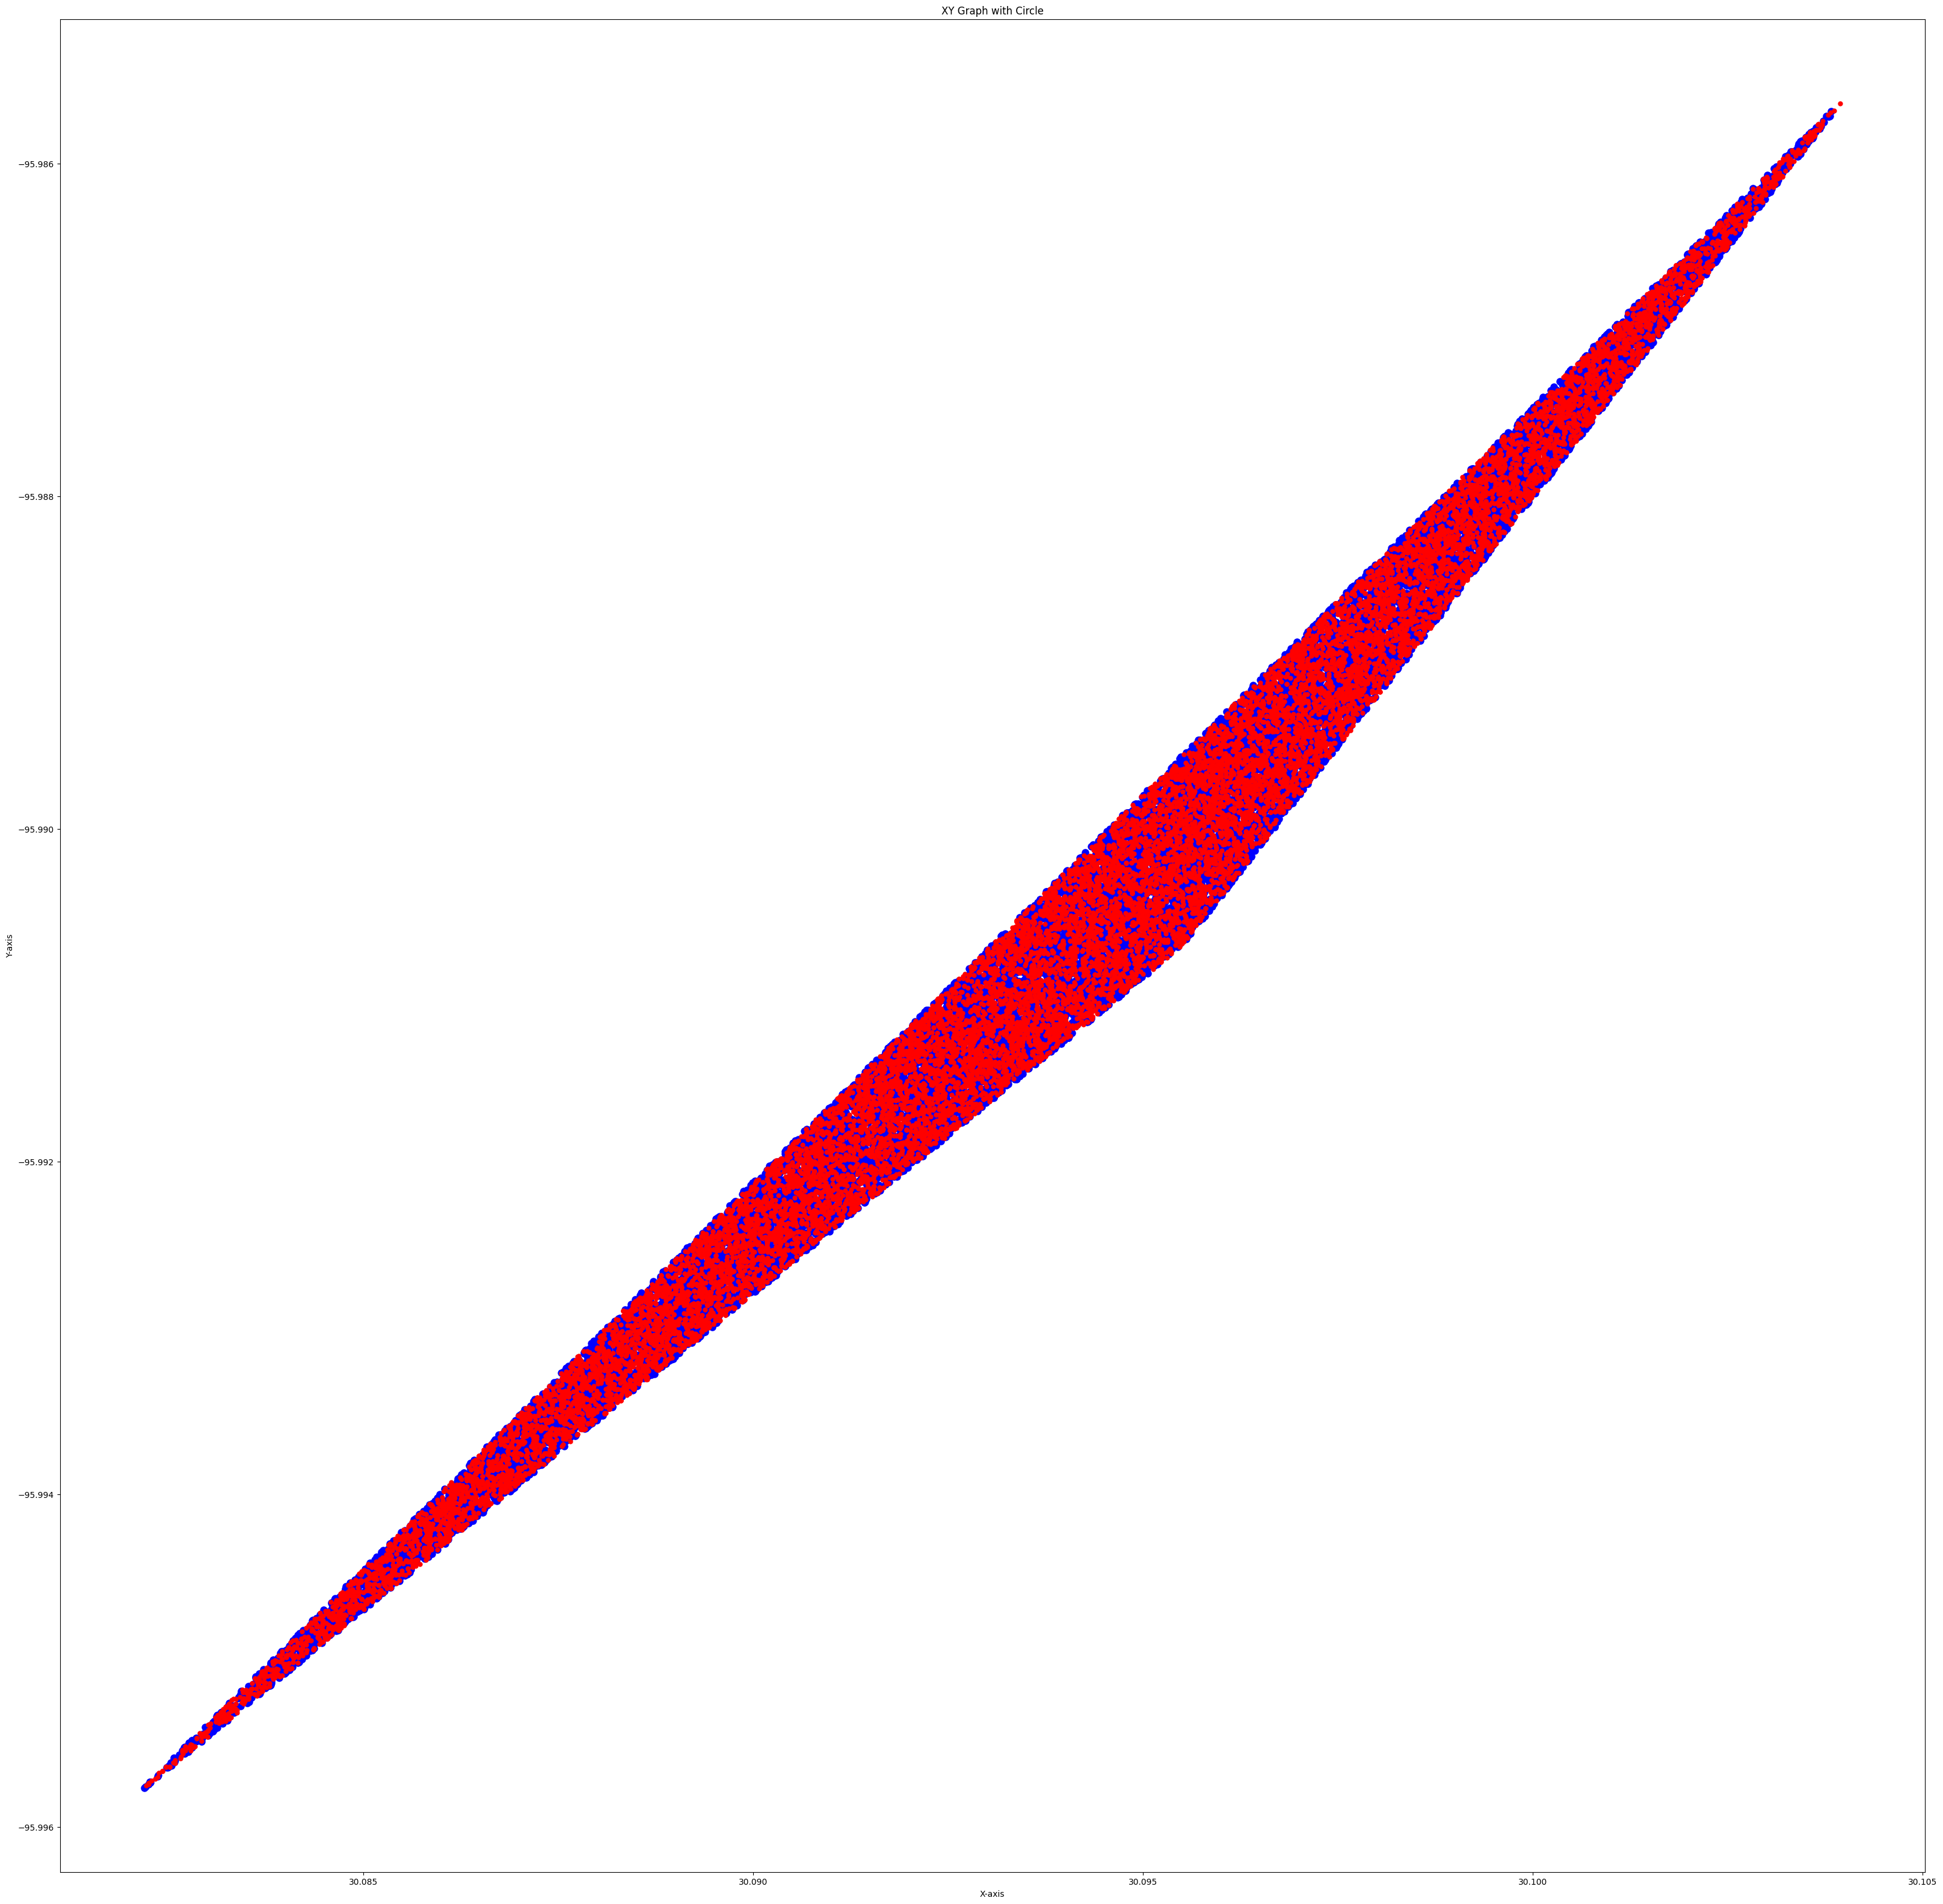

In [ ]:
# k-nearest neighbors for multioutput regression
from sklearn.neighbors import KNeighborsRegressor
# define model
model_kn = KNeighborsRegressor(n_neighbors = 1, weights = 'uniform',algorithm = 'brute',metric = 'minkowski')
# fit model
model_kn.fit(X_train, y_train)
# make a prediction
y_pred_kn = model_kn.predict(X_test)
# summarize prediction
print(y_pred_kn[0])
# Calculate the score
score = model_kn.score(X_test, y_pred_kn)

# Print the score
print(score)
print('Latitude MSE  :',mean_squared_error(y_test[:,0], y_pred_kn[:,0]))
print('Longitude MSE :',mean_squared_error(y_test[:,1], y_pred_kn[:,1]))
print('coefficient of determination: ',r2_score(y_test, y_pred_kn))
eval(model_kn,y_test, y_pred_kn)
plotcomp(y_test,y_pred_kn)

**Decision Tree for Multioutput Regression**

The example below fits a decision tree model on the multioutput regression dataset, then makes a single prediction with the fit model.

[ 30.09095123 -95.9919903 ]
1.0
Latitude MSE  : 4.331360345035675e-05
Longitude MSE : 9.218800455708034e-06
coefficient of determination:  -1.1058281260918217
MAE: 0.004 (0.000)


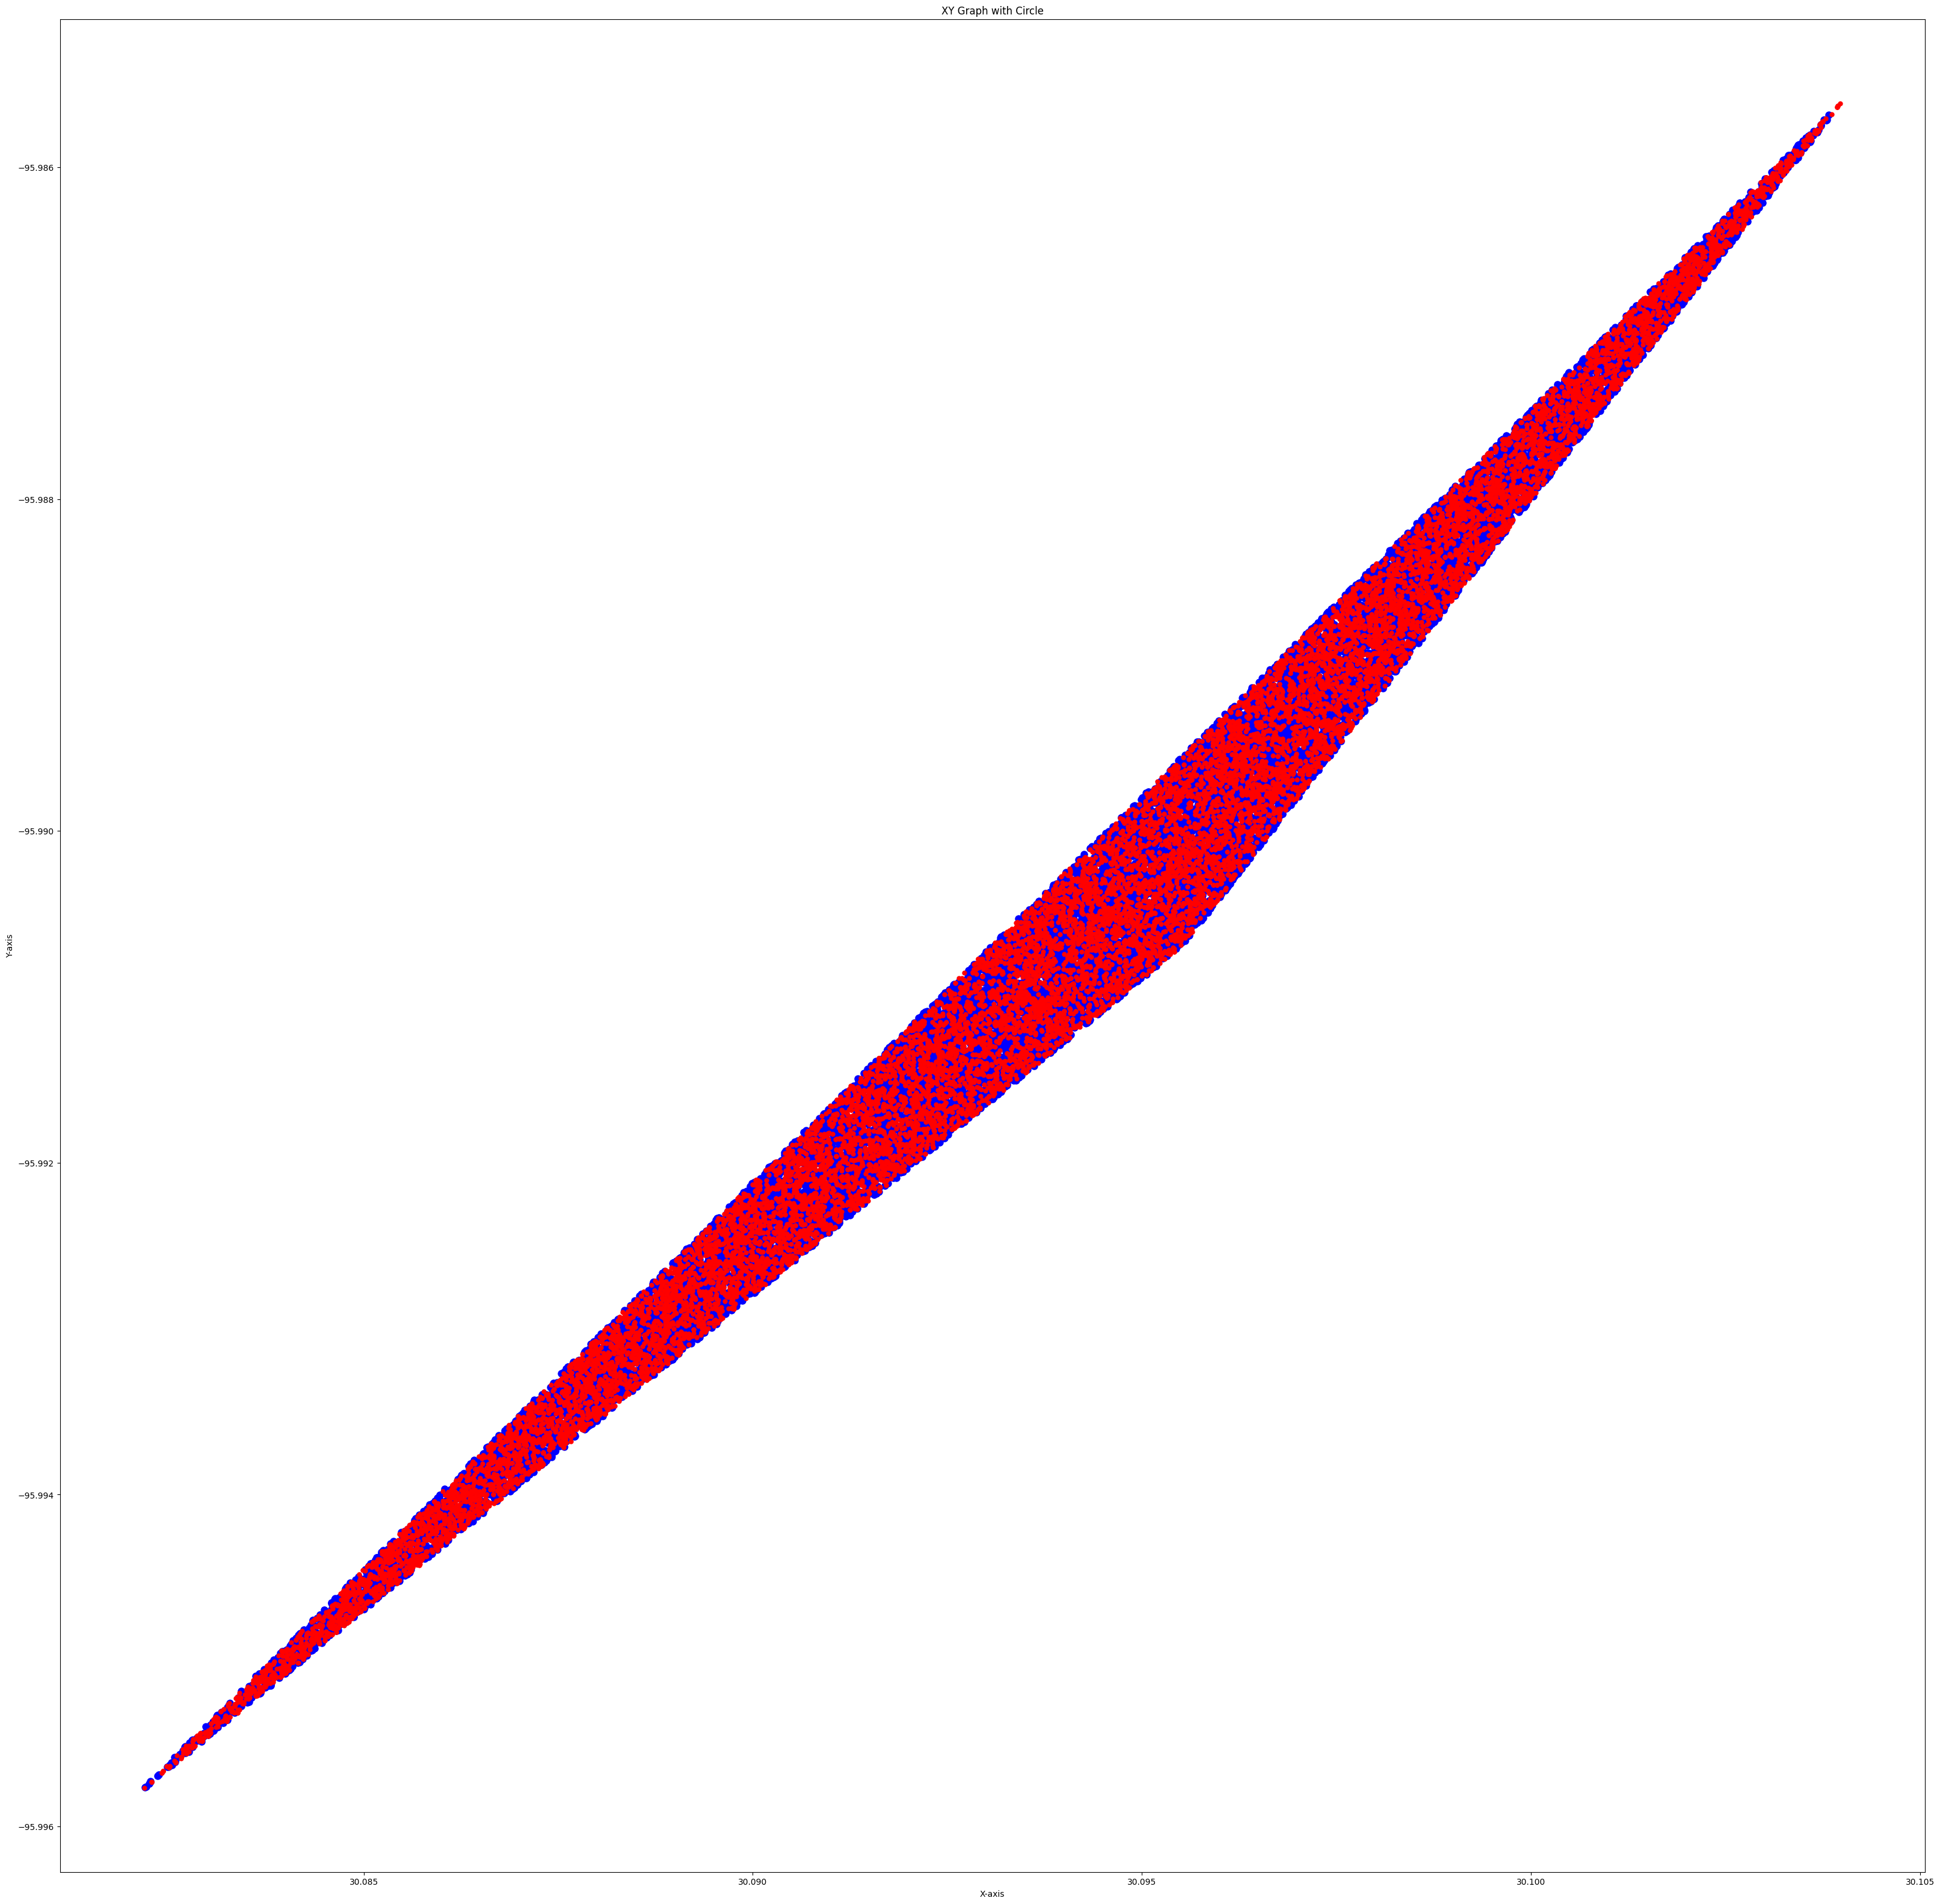

In [ ]:
# decision tree for multioutput regression
from sklearn.tree import DecisionTreeRegressor
# define model
#model_dt = DecisionTreeRegressor(max_depth=150,max_features='auto',random_state=12345)
model_dt = DecisionTreeRegressor()
# fit model
model_dt.fit(X_train, y_train)
# make a prediction
y_pred_dt = model_dt.predict(X_test)
# summarize prediction
print(y_pred_dt[0])
# Calculate the score
score = model_dt.score(X_test, y_pred_dt)

# Print the score
print(score)
print('Latitude MSE  :',mean_squared_error(y_test[:,0], y_pred_dt[:,0]))
print('Longitude MSE :',mean_squared_error(y_test[:,1], y_pred_dt[:,1]))
print('coefficient of determination: ',r2_score(y_test, y_pred_dt))
eval(model_dt,y_test, y_pred_dt)
plotcomp(y_test,y_pred_dt)

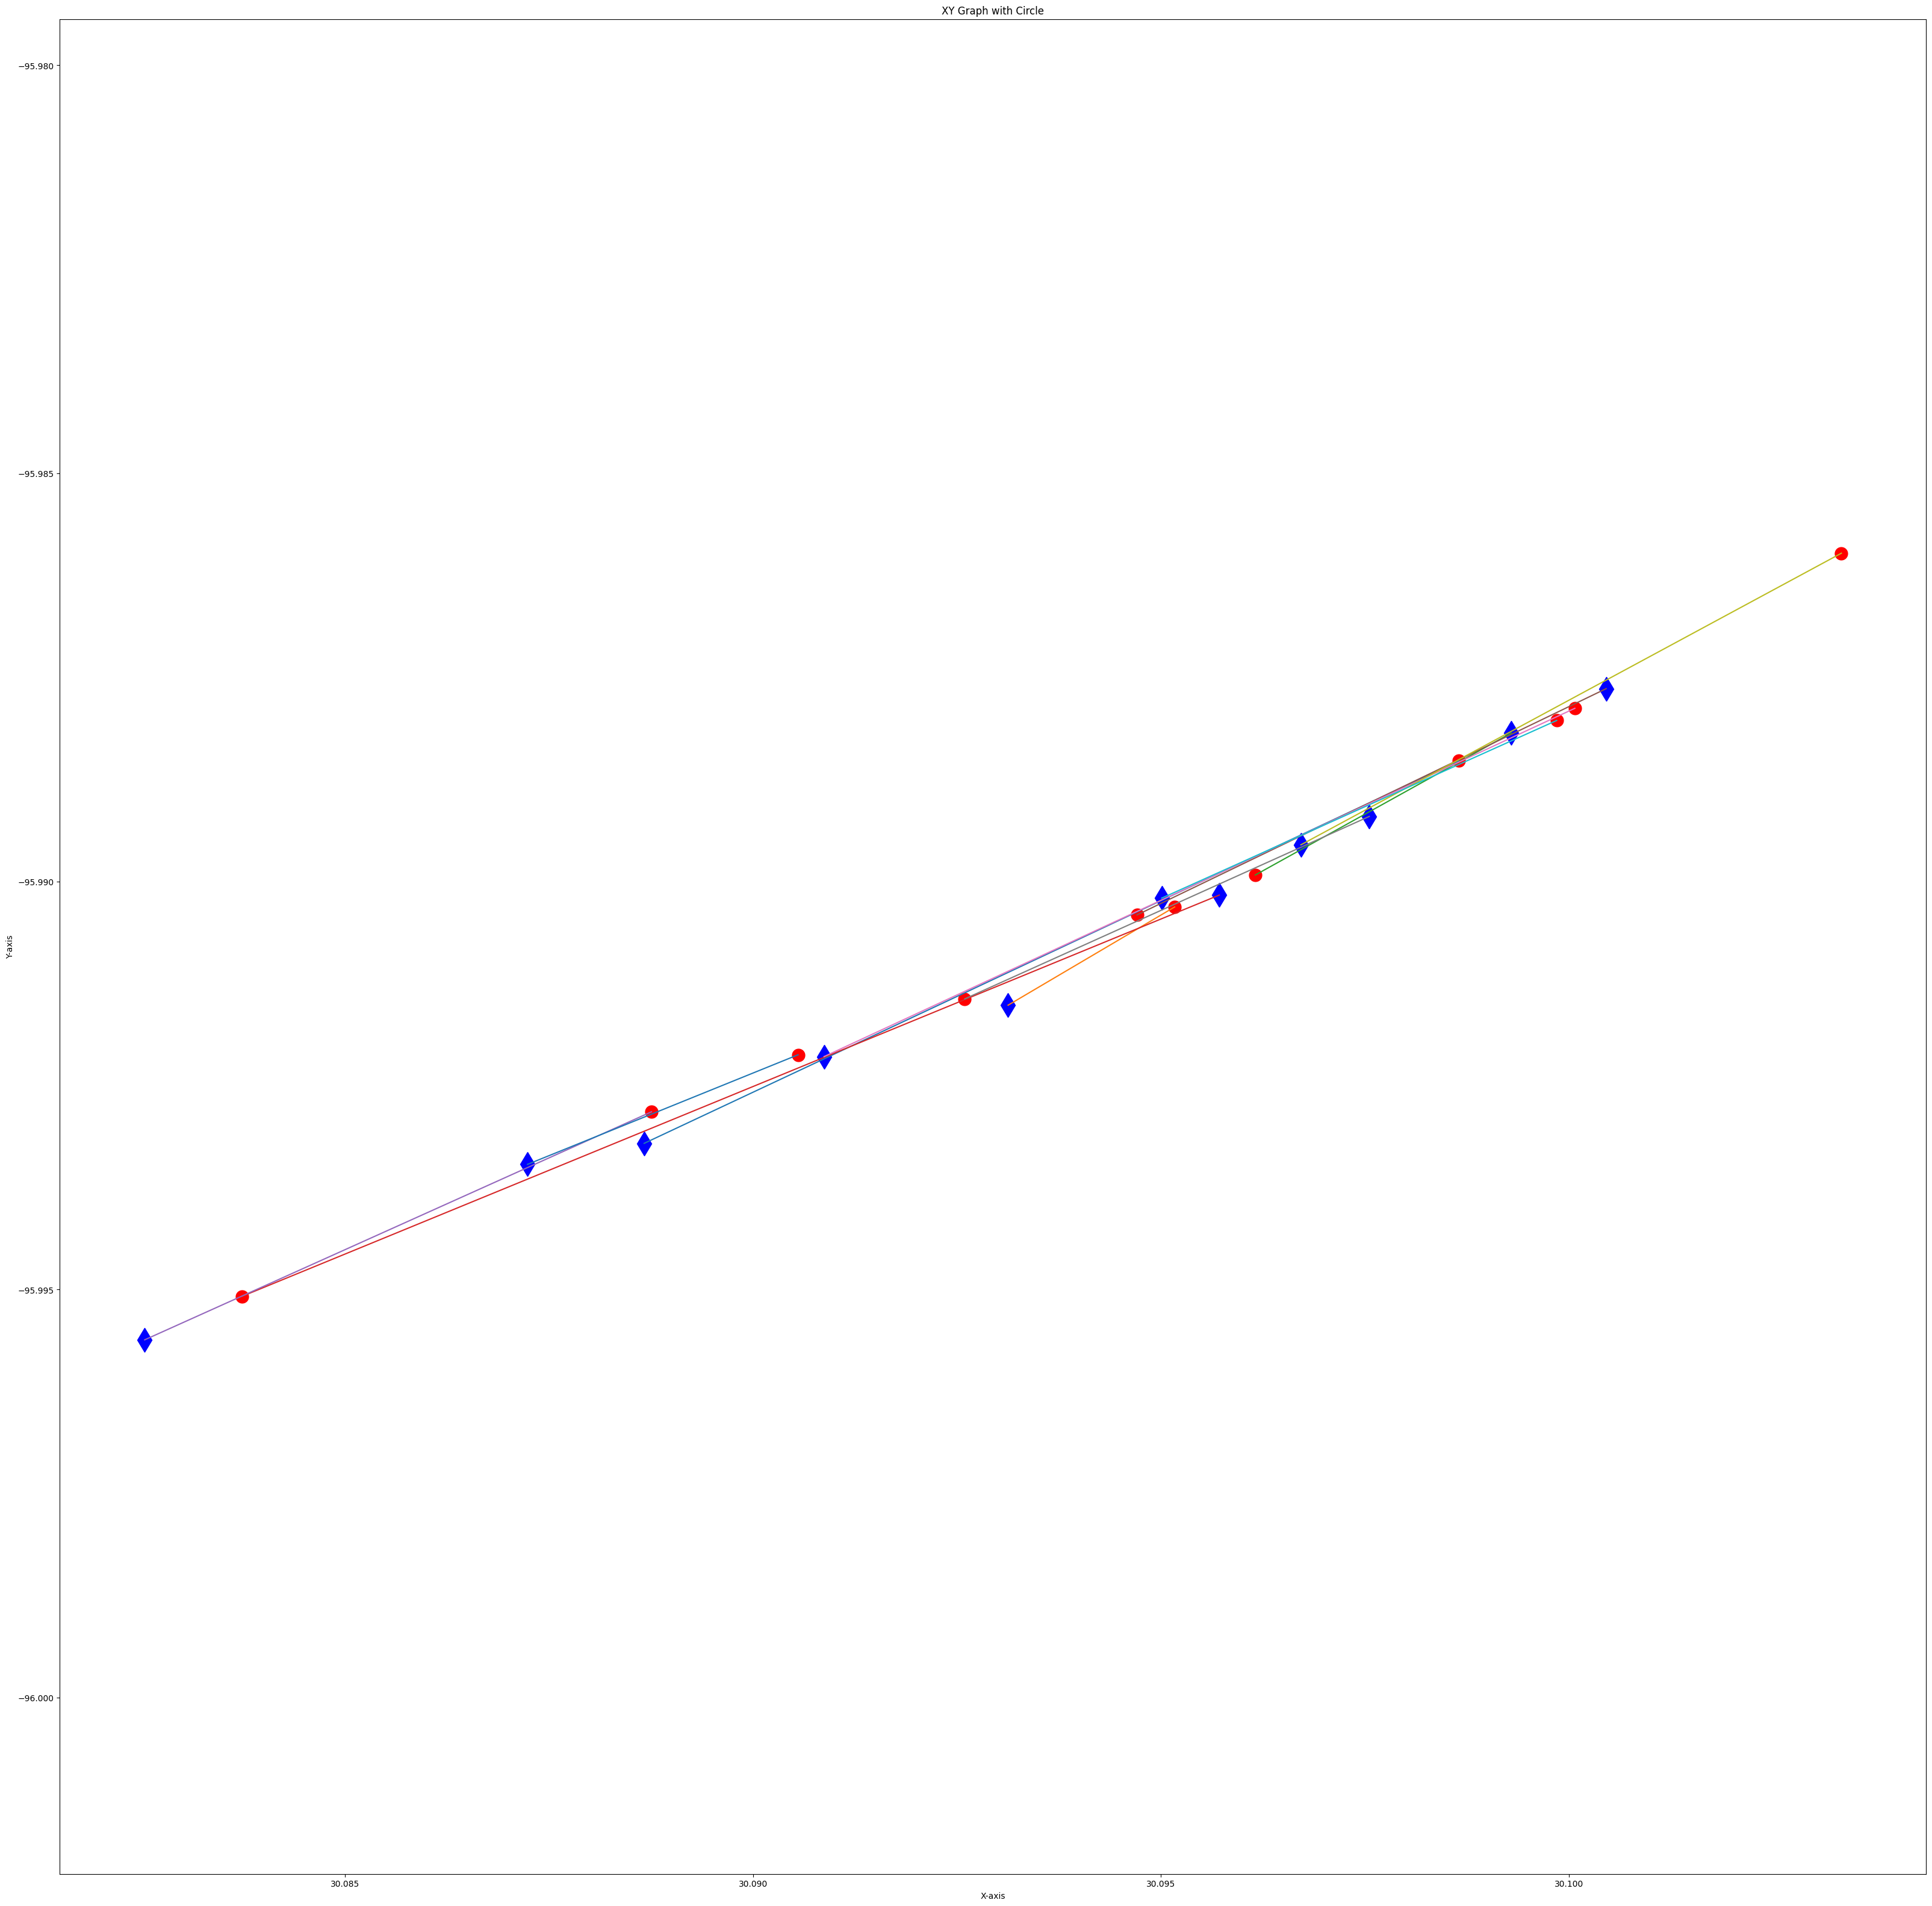

In [ ]:
import matplotlib.pyplot as plt
# Create a scatter plot
def plotcompz(y_test,y_pred):
    plt.rcParams["figure.figsize"] = (40,40)
    #plt.scatter(y_test[:,0],y_test[:,1], color='blue')
    #plt.scatter(y_pred_lt[:,0], y_pred_lt[:,1], color='red')
    plt.plot(y_test[:,0],y_test[:,1],'d', color='blue', markersize=20)
    plt.plot(y_pred[:,0], y_pred[:,1],'o', color='red', markersize=15)
    plt.plot([y_test[:,0],y_pred[:,0]],[y_test[:,1], y_pred[:,1]])
    # Add a circle
    #circle = plt.Circle((0, 0), radius=0.5, color='black')
    #plt.add_patch(circle)

    # Set the title and labels
    plt.axis('equal')
    plt.title('XY Graph with Circle')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # Show the plot
    plt.show()
plotcompz(y_test[10:1530:150],y_pred_dt[10:1530:150])

In [ ]:
print(np.stack((y_test[:,0], y_pred_dt[:,0]),axis=1))

[[30.08447957 30.09095123]
 [30.09790999 30.0936545 ]
 [30.09710768 30.09038895]
 ...
 [30.09306552 30.0900158 ]
 [30.09412623 30.09708642]
 [30.09146102 30.0873415 ]]


In [ ]:
y_test[:5],y_pred_dt[:5]

(array([[ 30.08447957, -95.99472907],
        [ 30.09790999, -95.98844927],
        [ 30.09710768, -95.98923034],
        [ 30.08917627, -95.99268839],
        [ 30.08791302, -95.99349033]]),
 array([[ 30.09095123, -95.9919903 ],
        [ 30.0936545 , -95.99065083],
        [ 30.09038895, -95.99220053],
        [ 30.09834657, -95.9885604 ],
        [ 30.09022071, -95.9923242 ]]))

# Deep Learing Tensor Flow